# Chapter 5 - Combining Information from Multiple Participants

In [1]:
from __future__ import division
import numpy as np; np.set_printoptions(precision=2)
from scipy import stats, optimize
from pandas import DataFrame, MultiIndex
import seaborn as sea
import matplotlib.pyplot as plt; plt.ion()

---
## An example of what could go wrong

Before we look at _proper ways_ to look at data across individuals, we first look at an example case where a simple average is severly misleading.

In this example, parameters $s$ and $r$ are estimated for each subject individually. Each subject learns a task, and their learning is modeled as beginning at some point $s$ from the beginning, and once it begins, their performance increases linearly at rate $r$ until max performance is reached.

Crucially (for the purpose of our example), there is lots of variation among subjects in parameter $s$ ($\sigma_s=20$), but little variation in $r$ ($\sigma_r=1.5$).

We will simulate some parameter estimates and data for this case, and plot a model resulted from averaged subjects, and then the individual models, to show the difference.

#### First we simulate the parameter estimates for each subject.

In [2]:
n_subjs = 9

# each "faked" parameter will come from a normal distribution
s_mu = 40
s_sigma = 20
r_mu = 5
r_sigma = 1.5

param_df = DataFrame(index=range(n_subjs),columns=['s','r'])

for s in range(n_subjs):
    param_df.loc[s,'s'] = np.round(np.random.normal(s_mu,s_sigma))
    param_df.loc[s,'r'] = np.random.normal(r_mu,r_sigma)

param_df

,s,r
0,41,5.54039
1,47,4.3058
2,33,4.731
3,22,6.06586
4,36,2.73857
5,37,4.35755
6,49,6.80544
7,44,3.10755
8,38,7.20357


#### Now we use those parameters to simulate data from each subject.

In [3]:
# simulate the performance of each subject across trials

n_trials = 120

performance_df = DataFrame(
    index=MultiIndex.from_product([
        range(n_subjs),
        range(n_trials)], names=['subj','trial']),
    columns=['performance'],
    dtype=float # important for aggregating later
)

# cycle through each trial of each subj
for subj, trial in performance_df.index:
    
    if trial < param_df.loc[subj,'s']:
        # if before subject's learning point, performance around 50%
        performance = np.random.normal(50,1)
    else:
        # increase according to subject's learning rate
        trials_learned = trial - param_df.loc[subj,'s']
        improvement = trials_learned * param_df.loc[subj,'r']
        performance = np.random.normal(50,1) + improvement

    # restrict performance to max at 100%
    if performance > 100:
        performance = 100
        
    performance_df.loc[(subj,trial),'performance'] = performance
    
performance_df.head()

performance
subj trial             
0    0        52.624910
     1        50.422702
     2        50.170918
     3        51.214858
     4        50.401009

#### Now we can plot the individual subject models underneath the averaged data.
_This should mimic figure 5.1_

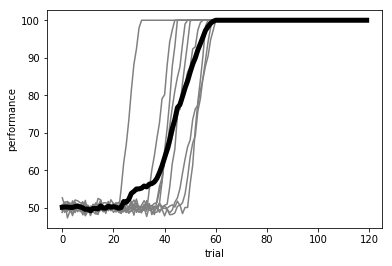

In [4]:
ax = plt.subplot()
ax.set_xlabel('trial')
ax.set_ylabel('performance')

x = range(n_trials)

for subj in range(n_subjs):
    y = performance_df.xs(subj)['performance'].values
    ax.plot(x,y,c='gray')
    
# get mean results
y = performance_df.groupby('trial')['performance'].mean()
ax.plot(x,y,c='black',linewidth=5)

---
## Fitting aggregate data

The easiest way to look at a group's data is to average or sum all their responses together. For example, aggregate all data into one, and then get modeling parameters on that data. Or as above, get everyone's modeling parameters and then average those.

A major downside to this method is the that you might **lose the complete profile** or shape of each individual's response.

This happens a lot with RTs, and a proposed solution is "Vincentizing", where parameters of the group distribution are estimated using **quantiles of the distribution** rather than the whole set of RTs. This is supposed to maintain information in the _shape_ of the distribution.

Below is an example where RTs are fit to a **Weibull distribution** via "Vincent averaging".

#### First let's plot a Weibull distribution to see what it looks like.

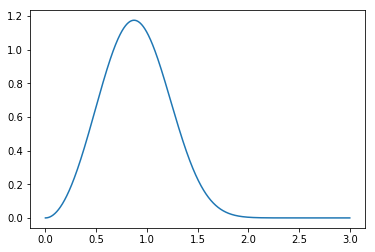

In [5]:
x = np.linspace(0,3,1000)

# c is the shape parameter of a Weibull
# the default mean and scale are 0 and 1, respectively
y = stats.weibull_min.pdf(x, c=3)

plt.plot(x,y)

#### Now let's just view what **quantiles** are, since Vincentizing is all about them.

We can redraw this Weibull, but add markers at some quantiles.

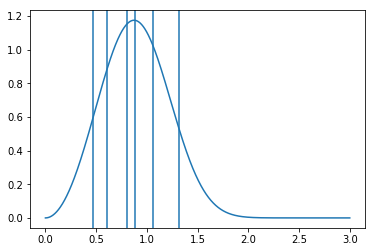

In [6]:
quantile_probabilities = [.1, .2, .4, .5, .7, .9]

plt.plot(x,y)

for q_p in quantile_probabilities:
    
    # get the quantile of this probability for this distribution
    q = stats.weibull_min.ppf(q_p, c=3)
    
    # draw the line
    plt.axvline(q)

I think quartiles make much more sense in terms of the cumulative distribution function (cdf), rather than the pdf, because quartile values are _the cumulative amount of the data that is below the specified probability_.

In the pdf above, the quartile value will indicate the total area under the curve _to the left of the quartile's line_.

In the cdf below, the quartile value for each vertical marker will match up with the value where it crosses the curve.

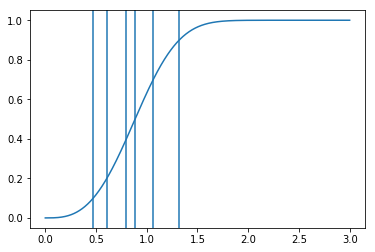

In [7]:
y = stats.weibull_min.cdf(x, c=3)

plt.plot(x,y)

for q_p in quantile_probabilities:
    q = stats.weibull_min.ppf(q_p, c=3)
    plt.axvline(q)

#### Fitting the Weibull to RTs from multiple participants

_The code below should match up to listing 5.1_

#### First we fake the Weibull distribution parameters for each subject.

In [8]:
n_subjs = 30

wb_params = DataFrame(index=range(n_subjs),columns=['shape','loc','scale'])

# pull the parameters from normal distributions
wb_params['shape'] = np.random.normal(2,0.25,size=n_subjs)
wb_params['loc']   = np.random.normal(250,50,size=n_subjs)
wb_params['scale'] = np.random.normal(200,50,size=n_subjs)

wb_params.head()

,shape,loc,scale
0,2.087930,230.701548,194.089123
1,2.002892,193.405104,228.117101
2,2.017644,268.181818,226.674940
3,1.725156,260.433566,167.447135
4,1.983967,328.423317,186.251641


In [9]:
print wb_params.mean()

shape      1.958567
loc      255.627023
scale    197.861603
dtype: float64


#### Now we want to simulate the data for each subject using the fake parameters.

In [10]:
n_obs = 80

data = DataFrame(
    index=MultiIndex.from_product([
        range(n_subjs),
        range(n_obs)], names=['subj','obs']),
    columns=['rt'],
    dtype=float)

for s in range(n_subjs):
    # extract Weibull RT using subj's parameters (again, c is shape parameter)
    shape, loc, scale = wb_params.loc[s,['shape','loc','scale']]
    observations = stats.weibull_min(c=shape,loc=loc,scale=scale).rvs(n_obs)
    data.loc[s,'rt'] = observations
    
data.head()

rt
subj obs            
0    0    360.240484
     1    253.055124
     2    440.388384
     3    354.371887
     4    484.781215

#### Let's plot everyone's data to check it out and see if we have a bunch of Weibulls.

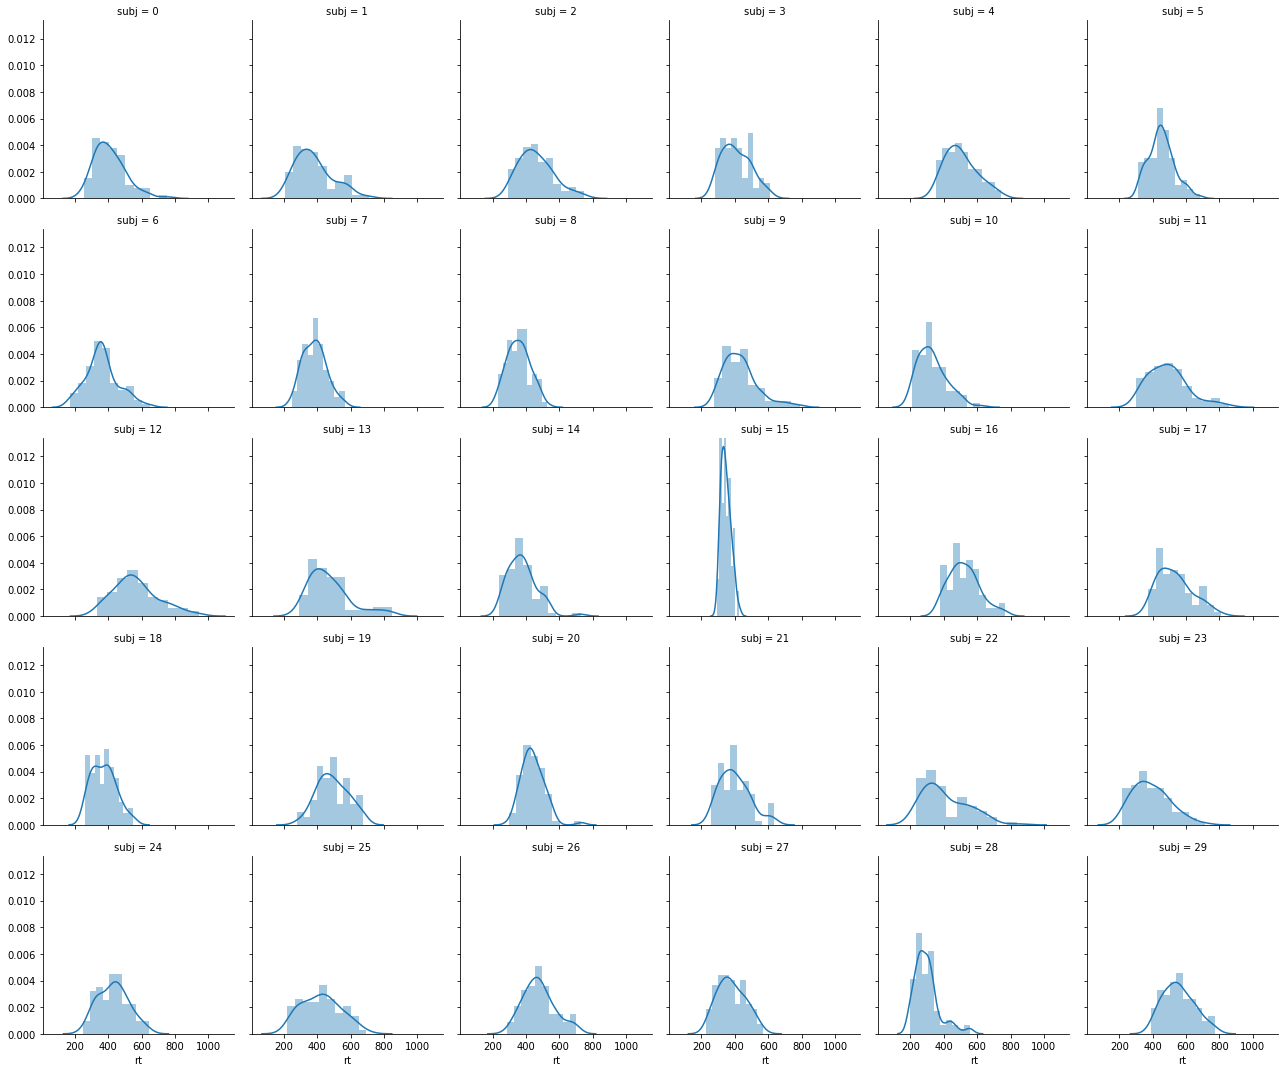

In [11]:
g = sea.FacetGrid(data=data.reset_index(), col='subj', col_wrap=6)
g = g.map(sea.distplot, 'rt', bins=10)

#### Begin the Vincentizing by making a dataframe that has quantiles for each subject rather than all RTs.

In [12]:
# pick the probabilities to get quantiles for
quant_probs = [.1, .3, .5, .7, .9]

quantiles = data.groupby('subj').quantile(quant_probs)
quantiles.index.rename('q_p',level=1,inplace=True)

quantiles.head(10)

rt
subj q_p            
0    0.1  319.756697
     0.3  353.096188
     0.5  393.084993
     0.7  444.966898
     0.9  526.183485
1    0.1  259.390893
     0.3  306.230598
     0.5  362.796838
     0.7  417.739187
     0.9  567.913291

#### Let's look at the quantiles for each subject on their own distribution.

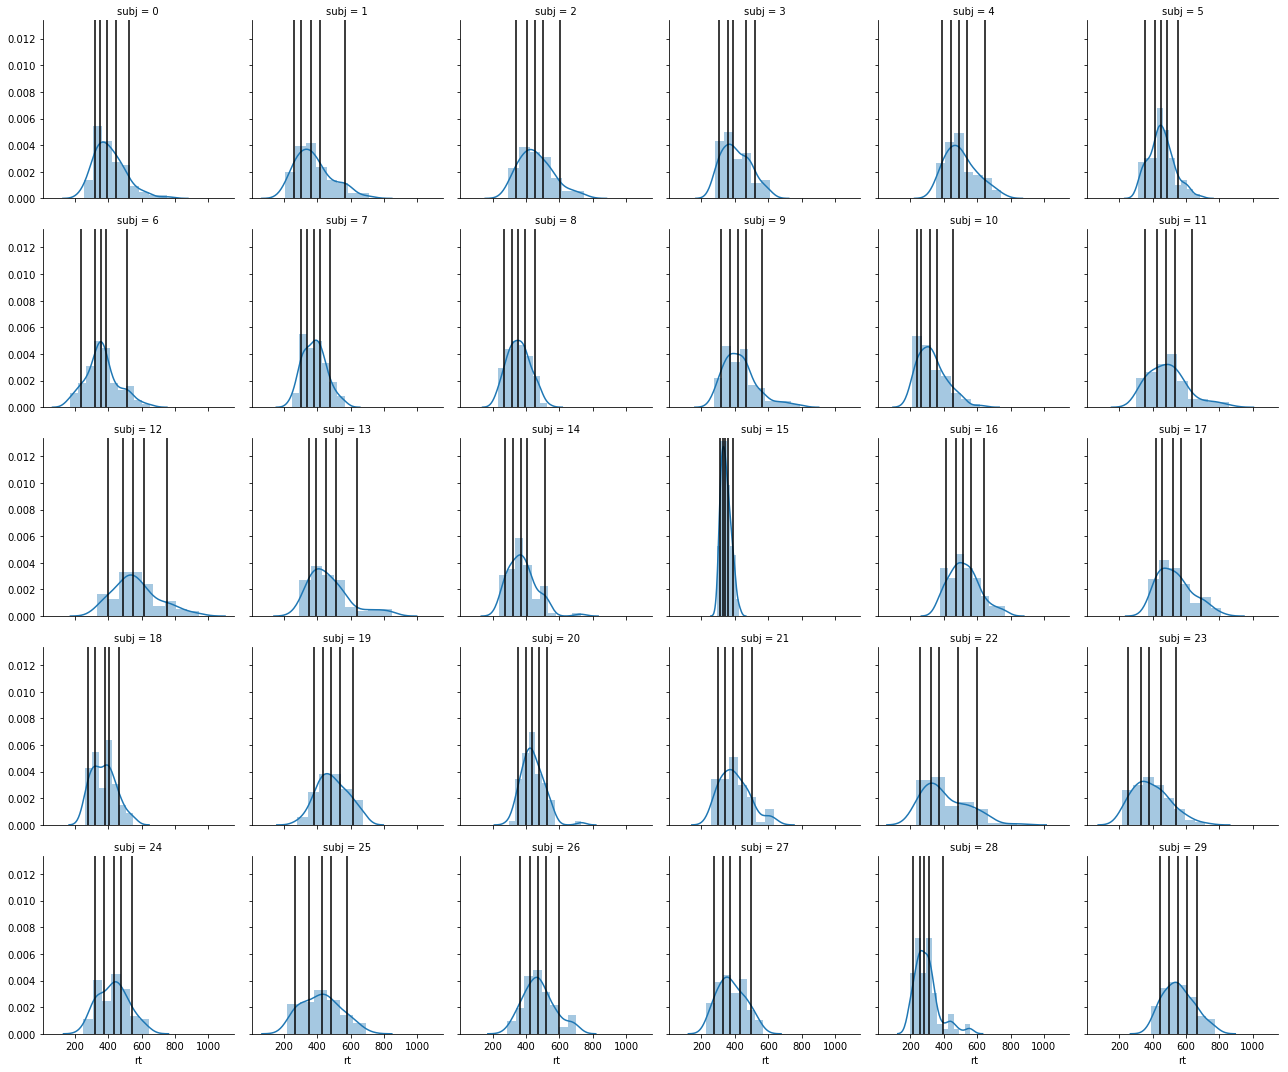

In [13]:
g = sea.FacetGrid(data=data.reset_index(), col='subj', col_wrap=6)
g = g.map(sea.distplot, 'rt',
#          hist_kws=dict(cumulative=True),kde_kws=dict(cumulative=True)
#          uncomment the above line to plot cdfs instead of pdfs
         )

for s in range(n_subjs):
    ax = g.axes[s]
    quants = quantiles.loc[s,'rt']
    # draw the vertical lines
    for q in quants:
        ax.axvline(q, c='black')

#### Fit the data (estimate parameters) using quantile information.

_This is the actual process of Vincentizing._

In [14]:
# get the group quantiles
vincent_qs = quantiles.groupby('q_p').mean().values.flatten()

print vincent_qs

[ 318.37  372.26  419.02  468.75  555.89]


In [15]:
def weib_qdev(params, quant_emp, quant_probs):
    '''
    params      - array of parameters from a weibull distribution
    quant_emp   - empirical quantiles being fit
    quant_probs - the quantile probabilities we want fit
    '''
    
    # prevent any parameters being zero by returning large discrepancy if so
    if np.any(params<=0):
        return 10000000

    # _given the current parameters_, get desired quantiles
    shape, loc, scale = params
    quant_pred = [ stats.weibull_min.ppf(q_p,c=shape,loc=loc,scale=scale) for q_p in quant_probs ]

    # get RMSD between predicted and observed quantities
    rmsd = np.sqrt(np.mean((quant_pred-quant_emp)**2))
    
    return rmsd


results = optimize.minimize(
    fun=weib_qdev,
    x0=[1,255,250], # start parameters
    args=(vincent_qs,quant_probs), # pass the empirical and desired probabilities to the obj func
)

print results

      fun: 1.0765390397804702
 hess_inv: array([[  8.17e-04,  -2.44e-03,  -4.45e-04],
       [ -2.44e-03,   1.31e+00,   1.29e-03],
       [ -4.45e-04,   1.29e-03,   2.86e-04]])
      jac: array([  1.49e-05,  -1.10e-06,  -1.03e-06])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 804
      nit: 29
     njev: 157
   status: 2
  success: False
        x: array([   1.93,  259.06,  192.15])


#### Plot the results by plotting the data with parameter estimates (ie, results) on top.

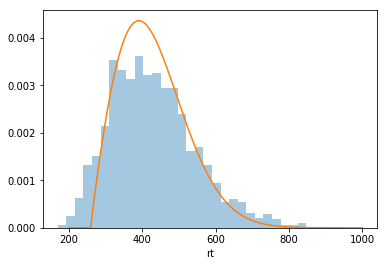

In [16]:
# plot the data histogram
ax = sea.distplot(data.rt, kde=False, norm_hist=True)

# create the pdf from the parameter estimates
x = np.linspace(200,1000,1000)
shape, loc, scale = results.x
y = stats.weibull_min.pdf(x,c=shape,loc=loc,scale=scale)

# plot the estimated distribution
ax.plot(x,y)

#### That's it, we Vincentized that data. Let's compare with results where we get MLE estimates for each subject and average them.

_The code below should mimic listing 5.2_

In [17]:
# make a discrepancy function for MLE

def wb_deviance(x, rts):

    # prevent any parameters being zero by returning large discrepancy if so
    if np.any(x<=0):
        return 10000000

    # get likelihood of data given these params
    shape, loc, scale = x
    likel = stats.weibull_min.pdf(rts-loc,c=shape,scale=scale)
    
    # flip that to -2log and sum
    deviation = np.sum(-2*np.log(likel))

    return deviation

# make empty dataframe
mle_results = DataFrame(index=range(n_subjs),columns=['shape','loc','scale'])

# get the estimates for each subject
for s in range(n_subjs):
    rts = data.loc[s,'rt'].values
    res = optimize.fmin(
        func=wb_deviance,
        x0=[1,100,225],
        args=(rts,),
        disp=False)
    mle_results.loc[s,['shape','loc','scale']] = res


mle_results.head()

/Users/remy/miniconda2/envs/workspace/lib/python2.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


,shape,loc,scale
0,1.84697,242.67,188.209
1,1.68683,198.41,204.386
2,1.79772,283.337,200.874
3,1.61173,272.055,153.003
4,1.72973,342.193,181.089


In [18]:
mle_results.aggregate(['mean','std'])

,shape,loc,scale
mean,1.931285,258.518760,191.158955
std,0.412996,56.948769,48.320084


#### Finally, let's plot everything we did.

1. histogram of our simulated data
2. black pdfs for our Vincent averaging model estimates
3. red pdfs for our MLE model estimates

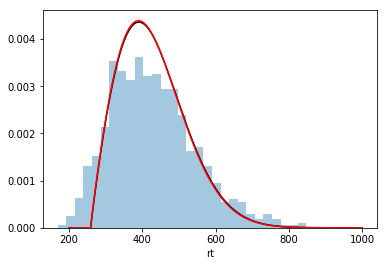

In [19]:
# plot data
ax = sea.distplot(data.rt, kde=False, norm_hist=True)

# make the pdf for the parameter estimates (results)
x = np.linspace(200,1000,1000)
shape, loc, scale = results.x
y = stats.weibull_min.pdf(x,c=shape,loc=loc,scale=scale)
ax.plot(x,y,c='black')

# and pdf for mle estimates
shape, loc, scale = mle_results.mean()
y = stats.weibull_min.pdf(x,c=shape,loc=loc,scale=scale)
ax.plot(x,y,c='red')

---
## Fitting subgroups of data

The above method(s) above have no way to compare the differences across individuals.

To address that, we will walk through two options that help to examine heterogeneity across subjects.
1. mixture modeling
2. k-means clustering

## Mixture modeling

Mixture modeing says that each data point might have come form one of $N$ different possible models (or random variables).

Here we focus on Gaussian mixture model, which assumes data are exclusively sampled from two or more gaussian distributions, each with its own mean and standard deviation.

The example we are playing with is about eye movements. In this task, sometimes eye movements are really quick, other times they're not.

So we have a bimodal distribution that we want to model, but the problem is that we cannot estimate the parameters of the two gaussian ditributions without knowing which RTs belong to which distribution!

We can't start solving this without first knowing parameters of each distribution, so we use the **Expectation-Maximization** method, where we makes guesses at the parameters and proceed iteratively.

#### Expectation-Maximization
1. make a guess at parameters from 2 gaussian distrns
2. calculate probability each data point belongs to each distrn
3. update parameter estiamtes based on thos probabilities

#### As usual, we start by simulating the data.
_The code below should mimic listing 5.3_

In [20]:
N = 1000
p_short = 0.3 # probability that it is an "express" (fast) sacccade

tru_params = {
    1: (100,10), # mean, sd
    2: (150,20)
}

# choose which of the 2 distributions each eye movement will come from
which_distrn = np.random.choice([1,2],p=(p_short,1-p_short),size=N,replace=True)

idata = DataFrame(index=range(N),columns=['distrn','mov_time'])

for i in range(N):
    idata.loc[i,'distrn'] = which_distrn[i]
    mu, sigma = tru_params[which_distrn[i]]
    idata.loc[i,'mov_time'] = np.random.normal(mu,sigma)


idata.head()

,distrn,mov_time
0,1,108.006
1,1,101.82
2,2,163.173
3,2,151.157
4,2,181.027


#### Iterate through parameter estimates using Expectation-Maximization.

In [21]:
# this function is needed in E-M
# There is a weighted-mean function available in numpy, but not weighted-std.
def weighted_sd(x,w,mu=None):
    if mu is None:
        mu = np.mean(x)
    wvar = sum(w*(x-mu)**2) / sum(w)
    return np.sqrt(wvar)

# initialize the model with some guessed parameters
mu1 = idata['mov_time'].mean() * 0.8
mu2 = idata['mov_time'].mean() * 1.2
sd1 = idata['mov_time'].std()
sd2 = idata['mov_time'].std()

# intialize the base probability for movements coming from the 2nd (slower) distribution
ppi = 0.5 # base probability for 2nd distribution
oldppi = 0.

while np.abs(ppi-oldppi) > .00001:
    
    oldppi = ppi

    # for convenience
    dat = idata['mov_time'].values.astype(float)

    ## "Expectation" step
    
    # calculate the probability that each data point in dat
    # comes from the second (vs first) Gaussian distrn.
    resp = (ppi*stats.norm.pdf(dat,loc=mu2,scale=sd2)) \
        / ((1-ppi)*stats.norm.pdf(dat,loc=mu1,scale=sd1) 
            + ppi*stats.norm.pdf(dat,loc=mu2,scale=sd2))

    ## "Maximization" step
    # change the mu and sd for both distributions based on the updated values
    
    # take weighted means for the data
    mu1 = np.average(dat,weights=1-resp)
    mu2 = np.average(dat,weights=resp)
    # weighted stds
    sd1 = weighted_sd(dat,1-resp,mu1)
    sd2 = weighted_sd(dat,resp,mu2)

    ppi = np.mean(resp)


print 'ESTIMATES:'
print '    distrn1: ({:.01f}, {:.01f})'.format(mu1,sd1)
print '    distrn2: ({:.01f}, {:.01f})'.format(mu2,sd2)
print '    proportion of distrn2: {:.02f}'.format(ppi)
print 'TRUE:'
print '    distrn1: ({:.01f}, {:.01f})'.format(tru_params[1][0],tru_params[1][1])
print '    distrn2: ({:.01f}, {:.01f})'.format(tru_params[2][0],tru_params[2][1])
print '    proportion of distrn2: {:.02f}'.format(1-p_short)

ESTIMATES:
    distrn1: (100.0, 10.7)
    distrn2: (150.4, 20.0)
    proportion of distrn2: 0.70
TRUE:
    distrn1: (100.0, 10.0)
    distrn2: (150.0, 20.0)
    proportion of distrn2: 0.70


#### Plot our data, the E-M results, and an MLE fit _to the two separate distributions_ (ie, cheating).
_This plot should partially emulate figure 5.2_

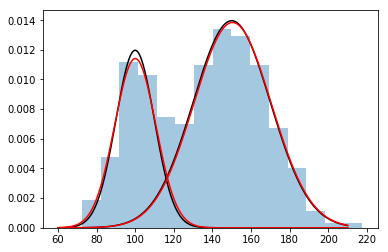

In [22]:
# plot data
ax = sea.distplot(idata['mov_time'].values.astype(float), kde=False, norm_hist=True)

# plot the normal pdfs with true parameters
x = np.linspace(60,210,1000)
for dstrn, params in tru_params.iteritems():
    y = stats.norm.pdf(x,loc=params[0],scale=params[1])
    # scale density according to probability of each distribution
    if dstrn == 1:
        y *= p_short
    else:
        y *= 1-p_short
    ax.plot(x,y,c='black')

    
# build the two distributions from E-M results (also scale these)

y = stats.norm.pdf(x,loc=mu1,scale=sd1) * (1-ppi)
ax.plot(x,y,c='red')

y = stats.norm.pdf(x,loc=mu2,scale=sd2) * ppi
ax.plot(x,y,c='red')

---
## K-Means clustering

While we don't have to do any manual k-means clustering because of widely available functions, worth noting that these are the steps:
1. Specify number of clusters, $k$, and initialize each cluster at a random point (vector).
2. Assign each object to the cluster to which it is closest (Euclidean).
3. Recalculate each cluster centroid by averaging across all objects that have been assigned to that cluster.
4. Keep repeating the previous two steps until the assignment of objects no longer changes.


The experiment we are simulating is a serial recall task. Subjects often show recency and primacy effects, but this is mostly from averaged data, and some have argued that individuals follow specific patterns, where some show just recency effecy effects, some just primacy, and others both. This gets washed out in averaging.

We can let k-means do its clustering, and then look at the data of the groups that are returned via clustering.

In this case, each subject gets represented with a 12-dimensional vector--one accuracy value for each position in the serial recall task. Importantly, some type of vector representation for each subject is needed for this method.

#### Obviously we start with simulating the data.

In [23]:
n_subjs = 80
n_positions = 12

# each subject will use one of three strategies
strategies = ['primacy','recency','both']

free_accuracy = DataFrame(
    index=MultiIndex.from_product([
        range(n_subjs),
        range(n_positions)],names=['subj','pos']),
    columns=['acc','strategy'])

# cycle through each subj
for s in range(n_subjs):
    
    # pick a strategy for them
    strategy = np.random.choice(strategies)
    free_accuracy.loc[s,'strategy'] = strategy
    
    # get their accuracy for each serial position
    for p in range(n_positions):

        if ((strategy in ['primacy','both'] and p in [0,1,2,3])
            or (strategy in ['recency','both'] and p in [8,9,10,11])):
            acc = np.random.normal(.75,.05)
        else:
            # accuracy hovers around 50% barring strategy-specific boosts
            acc = np.random.normal(.5,.05)

        free_accuracy.loc[(s,p),'acc'] = acc
        
free_accuracy.head()

acc strategy
subj pos                   
0    0    0.700957  primacy
     1    0.832473  primacy
     2    0.780122  primacy
     3    0.715971  primacy
     4    0.458944  primacy

#### Let's plot what we did to see if we have different strategies, and just so see how averaging effects our interpretation.

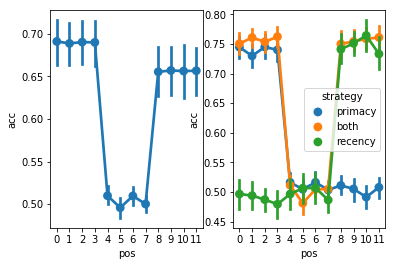

In [24]:
fig, (ax1,ax2) = plt.subplots(1,2)

sea.pointplot(data=free_accuracy.reset_index(),x='pos',y='acc',ax=ax1)
sea.pointplot(data=free_accuracy.reset_index(),x='pos',y='acc',hue='strategy',ax=ax2)

#### Let's cheat and say we know what there are 3 clusters, and do k-means clustering with size 3.

In [25]:
from sklearn.cluster import KMeans

# clustering needs the data in a [n_samples, n_features] array
acc_array = free_accuracy.reset_index().pivot(index='subj',columns='pos',values='acc').values.astype(float)

km = KMeans(n_clusters=3)

# cluster the data
km.fit(acc_array)

# extract the labels for each subjet
labels = km.labels_

# insert the labels into the dataframe
free_accuracy['k3_label'] = np.nan
for s, l in zip(range(n_subjs),labels):
    free_accuracy.loc[s,'k3_label'] = l
    
free_accuracy.head()

acc strategy  k3_label
subj pos                             
0    0    0.700957  primacy       1.0
     1    0.832473  primacy       1.0
     2    0.780122  primacy       1.0
     3    0.715971  primacy       1.0
     4    0.458944  primacy       1.0

#### Plot the same thing as above but notice how our kmeans clustering gives us our three main groups, _without knowing about them beforehand_.

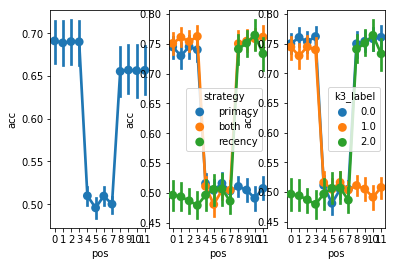

In [26]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3)
sea.pointplot(data=free_accuracy.reset_index(),x='pos',y='acc',ax=ax1)
sea.pointplot(data=free_accuracy.reset_index(),x='pos',y='acc',hue='strategy',ax=ax2)
sea.pointplot(data=free_accuracy.reset_index(),x='pos',y='acc',hue='k3_label',ax=ax3)

#### The Gap statistic

We cheated because we used a cluster size of three, knowing that we made three separate "groups" of subjects (by providing different strategies for them). But how can we empirically derive that cluster size? How can the data tell us how many subgroups there are? This is what the gap statistic is supposed to be for. For each k-means cluster size, you get a gap statistic for that cluster size. You then evaluate all your cluster sizes by comparing the gap statistic across them.

For each cluster size $k$, determine the difference (gap) between the observed within-cluster sum of squares (_inertia_) and that expected under some null reference model.

The expection under the null model is determind by bootstrapping from the null model.

In the simplest version (as in below), we sample each feature uniformly from the range of values observed for that feature in the dataset.

We can then choose a cluster size by finding the smallest $k$ such that $gap(k) >= gap(k+1)-s_{k+1}$, where $s$ is the standard error obtained from the bootstrap estimates.

_The portion of code below for finding a gap statistic is based on a script from [Zelazny7's github](https://github.com/Zelazny7/gap-statistic/blob/master/gap.py)._

In [27]:
cluster_sizes = [1,2,3,4,5,6,7,8]

gapstats = DataFrame(index=range(len(cluster_sizes)),
    columns=['cluster_size','inertia','ref_inertia','gap_stat'])

for i, k in enumerate(cluster_sizes):

    # get inertia value for kmeans of this cluster size
    km = KMeans(n_clusters=k, n_init=3)
    km.fit(acc_array)

    inertia = km.inertia_

    # simulate a null model using random data from the range of empirical data
    rand_inertias = []
    for j in range(10):
        rand_array = np.random.uniform(acc_array.min(),acc_array.max(),size=acc_array.shape)
        rand_inertia = KMeans(n_clusters=k, n_init=3).fit(rand_array).inertia_
        rand_inertias.append(rand_inertia)

    ref_inertia = np.mean(rand_inertias)

    # get the gap statistic
    gap_stat = np.log(ref_inertia - inertia)
    
    # save everything into dataframe
    gapstats.loc[i,'cluster_size'] = k
    gapstats.loc[i,'inertia'] = inertia
    gapstats.loc[i,'ref_inertia'] = ref_inertia
    gapstats.loc[i,'gap_stat'] = gap_stat
    

gapstats

,cluster_size,inertia,ref_inertia,gap_stat
0,1,10.9158,23.6904,2.54746
1,2,5.67806,21.3753,2.75348
2,3,2.38775,19.5902,2.84505
3,4,2.24466,18.5621,2.79223
4,5,2.17063,17.6693,2.74075
5,6,2.07079,16.5431,2.67224
6,7,2.0341,15.705,2.61527
7,8,1.92064,15.5129,2.6095


#### Plot gap stat by cluster size
_This plot should emulate (very roughly since we don't have that data) figure 5.4_

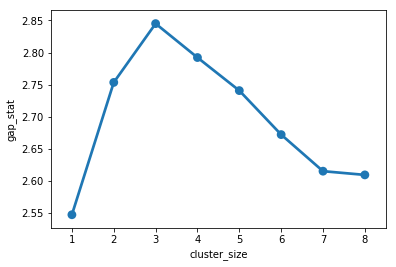

In [28]:
ax = sea.pointplot(data=gapstats,x='cluster_size',y='gap_stat')